In [2]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import copy

import pandas as pd
import numpy as np
import healpy as hp
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from astropy.io import fits
from tqdm import *
import matplotlib.pyplot as plt

from matplotlib import rcParams
import iminuit
from iminuit import Minuit, describe, Struct
import re

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw


# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

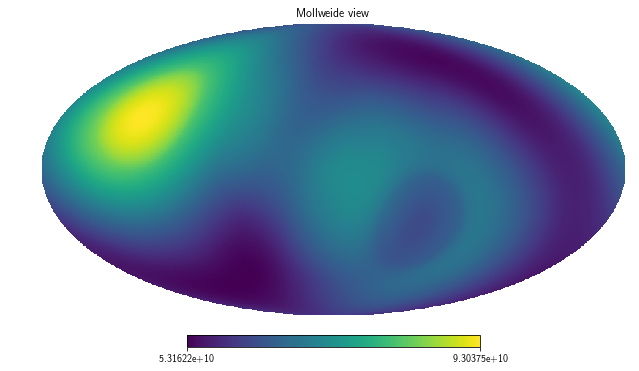

In [2]:
FermiData = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
hp.mollview(fermi_exposure)
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')
psc = np.load('fermi_data/template_psc.npy')
subhalos = np.load('MC/EinastoTemplate2.npy')
subhalos = subhalos

The number of parameters to be fit is 3
Template best-fit params are [13.9583217   1.06289421  0.90448092]


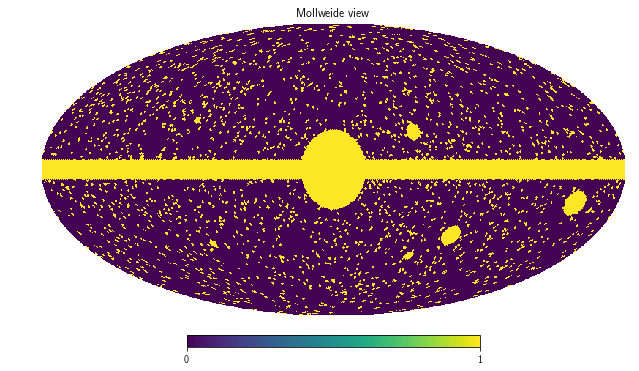

In [3]:
n = nptfit.NPTF(tag='norm')
n.load_data(FermiData, fermi_exposure)

pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
hp.mollview(mask)
n.load_mask(mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')

n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,10], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,10], False)

n.configure_for_scan()
scpy_min = minimize(lambda x: -n.ll(x), x0=[1.,1.,1], bounds=[[0.,30],[0.,30],[0.,30]], options={'disp':False,'ftol':1e-12}, method='SLSQP')
max_LL = -scpy_min['fun']
best_fit_params = scpy_min['x']
print("Template best-fit params are", best_fit_params)

In [4]:
fake_data_arr = [] 
xsec_inj = np.array([1e-22]) #(np.logspace(-30, -20, 10))[:-3]
trials = 20
for t in range(trials):
    fake_data_arr2 = []
    for fac in xsec_inj * 1e22:
        fake_data = 13.9583217*dif + 1.06289421*iso + 0.90448092*psc
        #fake_data = np.random.poisson(fake_data).astype(np.float64)
        #fake_data = np.load("/tigress/somalwar/Subhaloes/Subhalos/MC/subhalo_flux_map"+str(t)+"_10-15.npy")*fermi_exposure*fac 
        fake_data = np.load("MC/subhalo_flux_map0.npy")*fermi_exposure*fac
        fake_data = np.round(fake_data).astype(np.int32)
        fake_data_arr2.append(fake_data)
    fake_data_arr.append(fake_data_arr2)

In [2]:
LL_xsec_ary_arr = []
new_n_arr = []
d_arr_ary = []
for fi, fake_data_arr2 in enumerate(fake_data_arr):
    new_n_arr2 = []
    for fi, fake_data in enumerate(fake_data_arr2):
        n = nptfit.NPTF(tag='norm')
        n.load_data(fake_data, fermi_exposure)
        pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
        mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
        n.load_mask(mask)

        dif_copy = dif.copy()
        iso_copy = iso.copy()
        psc_copy = psc.copy()
        subhalos_copy = subhalos.copy()

        n.add_template(dif_copy, 'dif')
        n.add_template(iso_copy, 'iso')
        n.add_template(psc_copy, 'psc')

        n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
        n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
        n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,20], False)

        area_mask = len(mask[~mask])/len(mask) * 4*np.pi * (180/np.pi)**2
        xsec0 = 1e-22

        A0 = 10**(3.53399)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])
        n20 = 1.89914
        n10 = 10.0
        Fb0 = 10**(-7.71429)*np.average(fermi_exposure[~mask])    

#         A0 = 3.99418e-06 #1.39885e-06
#         n10 = 10.0
#         n20 = 1.33279863 #1.80089
#         Fb0 = 3640.23 #1264.28

        A0 = 10**(3.72097162)/np.average(fermi_exposure[~mask])*area_mask/np.sum(subhalos[~mask])
        n20 = 1.79403567
        n10 = 10.0
        Fb0 = 10**(-7.71429)*np.average(fermi_exposure[~mask])    
        print(np.log10(A0), np.log10(Fb0))

        new_n = copy.copy(n)
        new_n.add_template(subhalos_copy, 'subhalos', units='PS')
        new_n.add_non_poiss_model('subhalos', 
                               ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$F_b$'],
                                  fixed_params=[ [1,n10], [2,n20] ],
                                  units='counts')
        new_n.configure_for_scan(nexp=20)
        new_n_arr2.append(new_n)
    new_n_arr.append(new_n_arr2)

In [ ]:
xsec_rec = []
xsec_test = np.logspace(-40, -20, 101)
best_fit_params_arr = []
ll_xsec = []
for t in range(trials):
    ll_xsec.append([])
    for ix in tqdm_notebook(range(len(xsec_inj))):
        ll_xsec[-1].append([])
        for xsec in xsec_test:
            #minuit_min = iminuit.Minuit(lambda d, i, p: -new_n_arr[t][ix].ll([d, i, p, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]), d=13.9583217, i=1.06289421, p=0.90448092, fix_d=True, fix_i=True, fix_p=True, limit_d=(0.,20.), limit_i=(0.,3.), limit_p=(0.,3.), error_d=1e-1, error_i=1e-1, error_p=1e-1, print_level=1);
            minuit_min = iminuit.Minuit(lambda d, i, p: -new_n_arr[t][ix].ll([d, i, p, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]), d=0., i=0., p=0., fix_d=True, fix_i=True, fix_p=True, limit_d=(0.,20.), limit_i=(0.,3.), limit_p=(0.,3.), error_d=1e-1, error_i=1e-1, error_p=1e-1, print_level=1);
            minuit_min.migrad();
            ll=minuit_min.fval
            ll_xsec[t][ix].append(ll)

In [ ]:
xsec_rec = []
xsec_max = []
for t in range(trials):
    xsec_rec2 = []
    xsec_max2 = []
    for ix in range(len(xsec_inj)):
        ll_xsec[t][ix] = np.array(ll_xsec[t][ix])
        TS = -2*(ll_xsec[t][ix] - ll_xsec[t][ix][0])
        TS_max = np.amax(TS)
        argmax = np.argmax(TS)
        plt.plot(xsec_test, TS-TS_max)
        for ix, xsec in enumerate(xsec_test[argmax:]):
            if TS_max - TS[argmax+ix] > 2.71:
                xsec_rec2.append(xsec)
                xsec_max2.append(xsec_test[argmax])
                break
    xsec_rec.append(xsec_rec2)
    xsec_max.append(xsec_max2)
plt.xscale("log")
plt.ylim(-12, 3)

In [ ]:
print(xsec_rec)

[[1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23, 1.584893192461111e-23], [1e-22, 1e-22, 1e-22, 1e-22, 1e-22]]


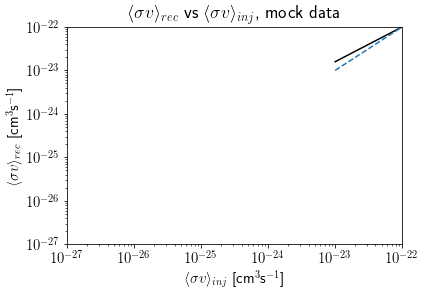

In [96]:
xsec_rec_arr = []
for ix in range(len(xsec_inj)):
    xsec_rec_arr2 = []
    for t in range(trials):
        xsec_rec_arr2.append(xsec_rec[t][ix])
    xsec_rec_arr.append(xsec_rec_arr2)
print(xsec_rec_arr)
plt.plot(xsec_inj, np.percentile(xsec_rec_arr, 50, axis=1), c="black")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 2.5, axis=1), np.percentile(xsec_rec_arr, 97.5, axis=1), facecolor="yellow")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 16, axis=1), np.percentile(xsec_rec_arr, 84, axis=1), facecolor="limegreen")
plt.plot(xsec_inj, xsec_inj, linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-27,1e-22)
plt.ylim(1e-27,1e-22)
plt.ylabel("$\\langle \\sigma v \\rangle_{rec}$ [cm$^3$s$^{-1}$]")
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$ [cm$^3$s$^{-1}$]")
plt.title("$\\langle \\sigma v \\rangle_{rec}$ vs $\\langle \\sigma v \\rangle_{inj}$, mock data")
#plt.legend()
plt.show()
plt.close()

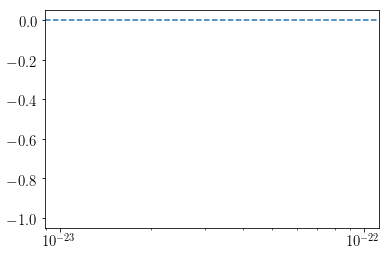

In [123]:
iso_norm = []
dif_norm = []
psc_norm = []
for t in range(trials):
    iso_norm_t = []
    dif_norm_t = []
    psc_norm_t = []
    for best_fit in best_fit_params_arr[len(xsec_inj)*t:len(xsec_inj)*(t+1)]:
        iso_norm_t.append(best_fit[0]['i']/1.06289421 - 1)
        dif_norm_t.append(best_fit[0]['d']/13.9583217 - 1)
        psc_norm_t.append(best_fit[0]['p']/0.90448092 - 1)
    iso_norm.append(iso_norm_t)
    dif_norm.append(dif_norm_t)
    psc_norm.append(psc_norm_t)
plt.plot(xsec_inj, np.percentile(iso_norm, 50, axis=1), label="iso", c="red")
plt.fill_between(xsec_inj, np.percentile(iso_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="iso", facecolor="red", alpha=0.2)
plt.plot(xsec_inj, np.percentile(dif_norm, 50, axis=1), label="dif", c="blue")
plt.fill_between(xsec_inj, np.percentile(dif_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="dif", facecolor="blue", alpha=0.2)
plt.plot(xsec_inj, np.percentile(psc_norm, 50, axis=1), label="psc", c="green")
plt.fill_between(xsec_inj, np.percentile(psc_norm, 16, axis=1), np.percentile(iso_norm, 84, axis=1), label="psc", facecolor="green", alpha=0.2)
plt.xscale("log")
plt.axhline(0,ls='--')
#lt.legend()

In [ ]:
ll = []
xsec_arr = np.logspace(-30,-20,101)
for new_n in tqdm_notebook(new_n_arr):
    ll_temp = []
    for xsec in (xsec_arr):
        #ll_temp.append(new_n.ll([13.9583217, 1.06289421,0.90448092, A0/(xsec/xsec0), Fb0]))
        ll_temp.append(new_n.ll([13.9583217, 1.06289421, 0.90448092, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]))
    ll.append(np.array(ll_temp))
ll = np.array(ll)

In [ ]:
for il, ll_arr in enumerate(ll):
    il = il
    p = plt.plot(xsec_arr, 2*(ll_arr-(ll_arr[0])))
    color = (p[0].get_color())
    plt.plot(xsec_inj[il]*np.ones(10), np.linspace(-3e15,3e15,10), c=color, linestyle="--")
plt.plot([1e-50], [1e-50], color="black", label="LL")
plt.plot([1e-50], [1e-50], color="black", linestyle="--", label="$\\langle \\sigma v \\rangle_{inj}$")
plt.axhline(-2.71,ls='--')
plt.xscale("log")
plt.ylim(-5, 3)
plt.xlim(1e-26, 1e-20)
plt.legend(fontsize=12)
plt.ylabel("$LL - LL_{max}$", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle$ [cm$^3$s$^{-1}$]", fontsize=15)
plt.title("Log Likelihood vs. Cross Section", fontsize=15)

In [4]:
print(np.logspace(-30, -15, 101)[60:])

[1.00000000e-21 1.41253754e-21 1.99526231e-21 2.81838293e-21
 3.98107171e-21 5.62341325e-21 7.94328235e-21 1.12201845e-20
 1.58489319e-20 2.23872114e-20 3.16227766e-20 4.46683592e-20
 6.30957344e-20 8.91250938e-20 1.25892541e-19 1.77827941e-19
 2.51188643e-19 3.54813389e-19 5.01187234e-19 7.07945784e-19
 1.00000000e-18 1.41253754e-18 1.99526231e-18 2.81838293e-18
 3.98107171e-18 5.62341325e-18 7.94328235e-18 1.12201845e-17
 1.58489319e-17 2.23872114e-17 3.16227766e-17 4.46683592e-17
 6.30957344e-17 8.91250938e-17 1.25892541e-16 1.77827941e-16
 2.51188643e-16 3.54813389e-16 5.01187234e-16 7.07945784e-16
 1.00000000e-15]


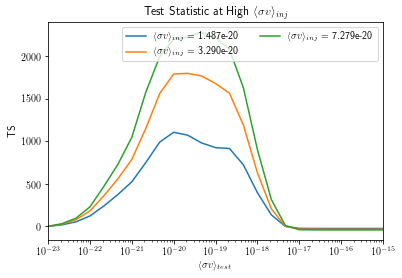

In [10]:
trials = 1
xsec_inj_t = []
xsec_rec_t = []
ll_arr = []
xsec_inj = np.concatenate((np.logspace(-30, -25, 15), np.logspace(-25, -15, 30)[1:] ))
#xsec_inj = np.logspace(-30, -20, 30)
xsec_test_arr = np.logspace(-23, -15, 25)
xsec_rec_all = []
TS_max_all = []
ll_ary = []
Ab_arr = np.zeros(101)
xsec_max_all = []
for x in xsec_inj:
    xsec_rec_all.append([])
    TS_max_all.append([])
    xsec_max_all.append([])
    ll_ary.append([])

#dir_siginj = 'EnergyBins/BlazarsTests/Results/FixAllBlaz_BlazFBlaz_MedianSCD/'
dir_siginj = 'EnergyBins/BlazarsTests/Results/ExactJ_100GeVtest/'
#dir_siginj = 'EnergyBins/BlazarsTests/Results/FixAllBlaz_BlazFBlazNorm_MedianSCD/'
for t in tqdm_notebook(range(trials)):
    xsec_inj_temp = []
    xsec_rec_temp = []
    for file in np.sort(os.listdir(dir_siginj)):
        if "True" in file: continue
        if '_'+str(t)+'_siginj_.npz' not in file: continue
        xsec_inj_file = float(re.findall(r'[\d+]?[.]?\d+e-\d+', file)[0])
        if xsec_inj_file not in xsec_inj: continue
        xsec_inj_temp.append(float(re.findall(r'[\d+]?[.]?\d+e-\d+', file)[0]))
        arr = np.load(dir_siginj+file)
        ll_ary[np.argmin(np.abs(xsec_inj_file - xsec_inj))].append(arr['arr_1'])
        if np.argmin(np.abs(xsec_inj_file-xsec_inj)) == 15: 
            Ab_arr = (arr['arr_2'])
        xsec_rec_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(arr['arr_0'])
        xsec_rec_temp.append(arr['arr_0'])
        TS = 2*(arr['arr_1'] - arr['arr_1'][0])
        if np.argmin(np.abs(xsec_inj_file - xsec_inj)) > 28 and np.argmin(np.abs(xsec_inj_file - xsec_inj)) < 32 and t == 0: # and np.argmin(np.abs(xsec_inj_file - xsec_inj)) % 2 == 0 and t == 0: 
            plt.plot(xsec_test_arr, TS, label="$\\langle \\sigma v \\rangle_{inj}$ = "+'{:0.3e}'.format(xsec_inj_file))
            plt.xscale("Log")
            plt.xlim(1e-23, 1e-15)
            plt.ylabel("TS")
            plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
            plt.title("Test Statistic at High $\\langle \\sigma v \\rangle_{inj}$")
            #plt.axvline(xsec_test_arr[np.argmin(np.abs(xsec_test_arr - (1e-20+1e-21)/2))])
            #plt.axvline(xsec_test_arr[1+np.argmin(np.abs(xsec_test_arr - (1e-20+1e-21)/2))])
            plt.legend(ncol=2)
        TS_xsec_ary = TS.copy()
        max_loc = np.argmax(TS_xsec_ary)
        max_TS = TS_xsec_ary[max_loc]
        xsec_max_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(xsec_test_arr[max_loc])
        TS_max_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(max_TS)
        xsec_rec = 1e-50
        for xi in range(max_loc, len(xsec_test_arr)):
            val = TS_xsec_ary[xi] - max_TS
            val_arr = TS_xsec_ary[xi:] - max_TS
            if np.all(val < -2.71 and np.all(val_arr < -2.71)):
                scale = (TS_xsec_ary[xi-1]-max_TS+2.71)/(TS_xsec_ary[xi-1]-TS_xsec_ary[xi])
                xsec_rec = xsec_test_arr[xi-1] + scale*(xsec_test_arr[xi] - xsec_test_arr[xi-1])
                #xsec_rec_all[ np.argmin(np.abs(xsec_inj_file-xsec_inj)) ].append(xsec_rec)
                break
    xsec_inj_t.append(np.array(xsec_inj_temp))
    xsec_rec_t.append(np.array(xsec_rec_temp))

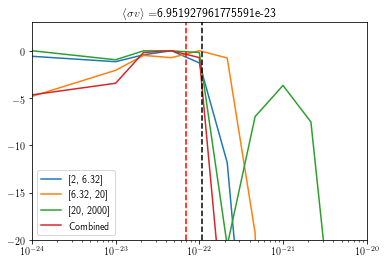

In [32]:
trials = 1
mass = 100
if mass <= 50:
    xsec_inj = np.logspace(-25, -16, 20)
    xsec_test_arr = np.concatenate((np.logspace(-26, -18, 25), np.logspace(-18, -15, 5)))
elif mass > 50 and mass <= 500:
    xsec_inj = np.logspace(-23, -15, 20)
    xsec_test_arr = np.concatenate(( np.logspace(-25, -23, 3), np.logspace( -23, -15, 25 ) ))
elif mass > 500 and mass <= 1500:
    xsec_inj = np.logspace(-22, -14, 20)
    xsec_test_arr = np.concatenate((np.logspace(-24, -21.5, 4)[:3], np.logspace( -22, -14, 25  )))
elif mass > 1500:
    xsec_inj = np.logspace(-20, -14, 20)
    xsec_test_arr = np.concatenate((np.logspace(-22, -20.5, 4), np.logspace( -20, -12, 25  )))
# xsec_test_arr = np.logspace( -22, -14, 25  )
#  # 1000 GeV
# xsec_inj = np.logspace( -22, -14, 20 ) # 1000 GeV
# #xsec_inj = np.logspace(-25, -16, 20) # 10 GeV
# #xsec_test_arr = np.concatenate((np.logspace(-26, -18, 25), np.logspace(-18, -15, 5))) # 10 GeV
xsec_rec_all = []
TS_max_all = []
xsec_max_all = []

for ix, xsec in enumerate(xsec_inj):
    xsec_rec_all.append([])
    TS_max_all.append([])
    xsec_max_all.append([])
    
    for trial in range(trials):
        ll_arr = []
        ll_arr0 = []
        ll_arr1 = []
        ll_arr2 = []
        for xsect in xsec_test_arr:
            file = ("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/slurm/slurm_FIsoFDifBlazarsFBlaz_"+str(int(mass))+"GeV_"+str(xsec)+"_"+str(trial)+"_siginj__"+str(xsect)+".out")
            done = False
            if os.path.isfile(file):
                for line in open(file):
                    if 'array' in line and not done:
                        done = True
                        ll_arr_ebins = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
                        ll_arr.append(float(ll_arr_ebins[2]))
                        ll_arr0.append(float(ll_arr_ebins[0]))
                        ll_arr1.append(float(ll_arr_ebins[1])-float(ll_arr_ebins[0]))
                        ll_arr2.append(float(ll_arr_ebins[2])-float(ll_arr_ebins[1]))
            if not done:
                print(file)
                if len(ll_arr)>=1:
                    ll_arr2.append(-1e5) #ll_arr2[-1])
                    ll_arr0.append(-1e5) #ll_arr0[-1])
                    ll_arr1.append(-1e5) #ll_arr1[-1])
                    ll_arr.append(-1e5) #ll_arr[-1])
                else:
                    ll_arr2.append(-1e5)
                    ll_arr0.append(-1e5)
                    ll_arr1.append(-1e5)
                    ll_arr.append(-1e5)
        ll_arr = np.array(ll_arr)
        ll_arr0 = np.array(ll_arr0)
        ll_arr1 = np.array(ll_arr1)
        ll_arr2 = np.array(ll_arr2)
#         print(2, min(ll_arr2-max(ll_arr2)))
#         print(1, min(ll_arr1-max(ll_arr1)))
#         print(0, min(ll_arr0-max(ll_arr0)))
        TS = 2*(ll_arr-ll_arr[0])
        TS0 = 2*(ll_arr0-ll_arr0[0])
        TS1 = 2*(ll_arr1-ll_arr1[0])
        TS2 = 2*(ll_arr2-ll_arr2[0])
        max_loc = np.argmax(TS)
        max_TS = TS[max_loc]
        xsec_max_all[ix].append(xsec_test_arr[max_loc])
        TS_max_all[ix].append(max_TS)
        xsec_rec = 1e-25
        for xi in range(max_loc, len(xsec_test_arr)-1):
            val = TS[xi] - max_TS
            val_arr = TS[xi:] - max_TS
            if val < -2.71:
                scale = (TS[xi-1]-max_TS+2.71)/(TS[xi-1]-TS[xi])
                xsec_rec = xsec_test_arr[xi-1] + scale*(xsec_test_arr[xi] - xsec_test_arr[xi-1])
                break
        if xsec_inj[np.argmin(np.abs(1e-22-xsec_inj))] == xsec:
            plt.figure()
            plt.title("$\\langle \\sigma v \\rangle = $" + str(xsec))
            plt.plot(xsec_test_arr, TS0-max(TS0), label="[2, 6.32]")
            plt.plot(xsec_test_arr, TS1-max(TS1), label="[6.32, 20]")
            plt.plot(xsec_test_arr, TS2-max(TS2), label="[20, 2000]")
            plt.plot(xsec_test_arr, TS-max(TS), label="Combined")
            plt.axvline(xsec, c="red", ls="--")
            plt.axvline(xsec_rec, c="black", ls="--")
            plt.xscale("log")
            plt.legend()
            plt.ylim(-20,3)
            plt.xlim(1e-24, 1e-20)
#         if xsec_inj[np.argmin(np.abs(5e-19-xsec_inj))] == xsec:
#             plt.figure()
#             plt.title("$\\langle \\sigma v \\rangle = $" + str(xsec))
#             plt.plot(xsec_test_arr, TS0-max(TS0), label="[2, 6.32]")
#             plt.plot(xsec_test_arr, TS1-max(TS1), label="[6.32, 20]")
#             plt.plot(xsec_test_arr, TS2-max(TS2), label="[20, 2000]")
#             plt.plot(xsec_test_arr, TS-max(TS), label="Combined")
#             plt.axvline(xsec, c="red", ls="--")
#             plt.axvline(xsec_rec, c="black", ls="--")
#             plt.xscale("log")
#             plt.legend()
#             plt.ylim(-20,3)
#         if xsec_inj[np.argmin(np.abs(3e-17-xsec_inj))] == xsec:
#             plt.figure()
#             plt.title("$\\langle \\sigma v \\rangle = $" + str(xsec))
#             #plt.plot(xsec_test_arr, TS0-max(TS0), label="[2, 6.32]")
#             #plt.plot(xsec_test_arr, TS1-max(TS1), label="[6.32, 20]")
#             plt.plot(xsec_test_arr, TS2-max(TS2), label="[20, 2000]")
#             plt.plot(xsec_test_arr, TS-max(TS), label="Combined")
#             plt.axvline(xsec, c="red", ls="--")
#             plt.axvline(xsec_rec, c="black", ls="--")
#             plt.xscale("log")
#             plt.legend()
#             plt.ylim(-20,3)

        xsec_rec_all[ix].append(xsec_rec)

In [19]:
xsec_rec_ave = []
xsec_rec_1stdd = []
xsec_rec_1stdu = []
for i in range(len(xsec_rec_all)):
    if len(xsec_rec_all[i]) == 0: 
        xsec_rec_ave.append(0)
        xsec_rec_1stdd.append(0)
        xsec_rec_1stdu.append(0)
        continue
    xsec_rec_all[i] = np.array(xsec_rec_all[i])
    xsec_rec_ave.append(np.percentile(xsec_rec_all[i], 50))
    xsec_rec_1stdd.append(np.percentile(xsec_rec_all[i], 16))
    xsec_rec_1stdu.append(np.percentile(xsec_rec_all[i], 84))
    
xsec_max_ave = []
xsec_max_1stdd = []
xsec_max_1stdu = []
for i in range(len(xsec_max_all)):
    if len(xsec_max_all[i]) == 0: 
        xsec_max_ave.append(0)
        xsec_max_1stdd.append(0)
        xsec_max_1stdu.append(0)
        continue

    xsec_max_all[i] = np.array(xsec_max_all[i])
    xsec_max_ave.append(np.percentile(xsec_max_all[i], 50))
    xsec_max_1stdd.append(np.percentile(xsec_max_all[i], 16))
    xsec_max_1stdu.append(np.percentile(xsec_max_all[i], 84))

TS_max_ave = []
TS_max_1stdd = []
TS_max_1stdu = []
for i in range(len(TS_max_all)):
    if len(TS_max_all[i]) == 0: 
        TS_max_ave.append(0)
        TS_max_1stdd.append(0)
        TS_max_1stdu.append(0)
        continue
    TS_max_all[i] = np.array(TS_max_all[i])
    TS_max_ave.append(np.percentile(TS_max_all[i], 50))
    TS_max_1stdd.append(np.percentile(TS_max_all[i], 16))
    TS_max_1stdu.append(np.percentile(TS_max_all[i], 84))

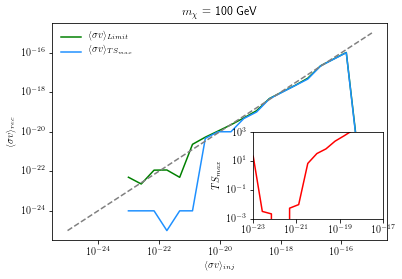

In [20]:
fig, ax1 = plt.subplots()

left, bottom, width, height = [0.59, 0.20, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
# for t in range(trials):
#     xsec_rec_arr = xsec_rec_t[t][xsec_inj_t[t].argsort()]
#     #plt.plot(np.sort(xsec_inj_t[t]), xsec_rec_arr)
ax1.set_title("$m_{\chi}$ = "+str(int(mass))+" GeV")
ax1.plot(xsec_inj, xsec_rec_ave, c="green", label="$\langle\sigma v \\rangle_{Limit}$")
ax1.fill_between(xsec_inj, xsec_rec_1stdd, xsec_rec_1stdu, facecolor="green", alpha=0.3)
ax1.plot(xsec_inj, xsec_max_ave, c="dodgerblue", label="$\langle\sigma v \\rangle_{TS_{max}}$")
ax1.fill_between(xsec_inj, xsec_max_1stdd, xsec_max_1stdu, facecolor="dodgerblue", alpha=0.3)
ax1.plot((xsec_test_arr), np.sort(xsec_test_arr), linestyle="--", c="grey")
#ax1.fill_between( [-100, 100], [1.7886495290574352e-25, 1.7886495290574352e-25], [1.4849682622544576e-23, 1.4849682622544576e-23], alpha=0.3, facecolor="grey", label="Traditional Limit Range") #100 GeV
#ax1.fill_between( [-100, 100], [1.7886495290574352e-25, 1.7886495290574352e-25], [1.176811952435004e-23, 1.176811952435004e-23], alpha=0.3, facecolor="grey", label="Traditional Limit Range") #10 GeV

ax1.set_yscale("log")
ax1.set_xscale("log")
#ax1.set_xlim(1e-20,1e-17)
#ax1.set_ylim(1e-20,1e-17)
ax1.set_xlabel("$\langle\sigma v \\rangle_{inj}$")
ax1.set_ylabel("$\langle\sigma v \\rangle_{rec}$")
ax2.plot(xsec_inj, TS_max_ave, c="red")
ax2.fill_between(xsec_inj, TS_max_1stdd, TS_max_1stdu, facecolor="red", alpha=0.3)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlim(1e-23,1e-17)
ax2.set_ylim(1e-3, 1e3)
ax2.set_ylabel("$TS_{max}$")
ax1.legend(frameon=False)

In [12]:
ebins = 2*np.logspace(-1,3,41)[0:41]
my_iebins = [10, 15, 20, 40]
print(ebins[my_iebins])

[   2.            6.32455532   20.         2000.        ]


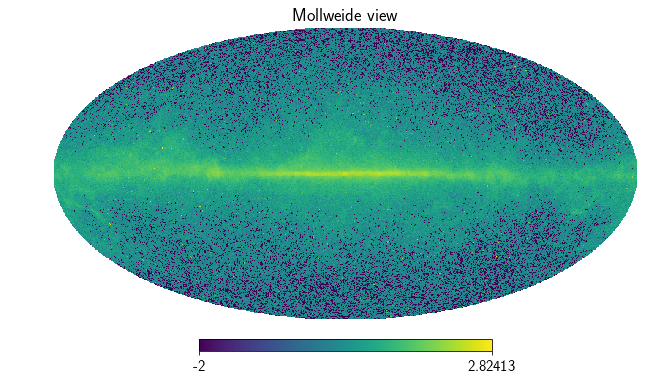

In [41]:
hp.mollview(np.log10(1e-2+np.load("EnergyBins/BlazarsTests/MPITemp/fake_data0__FIsoFDifBlazarsFBlaz_FixSigNew_1e-30_5_siginj_.npy")))

In [12]:
print(np.logspace(-25, -15, 30)[1:][7:22])

[5.73615251e-23 1.26896100e-22 2.80721620e-22 6.21016942e-22
 1.37382380e-21 3.03919538e-21 6.72335754e-21 1.48735211e-20
 3.29034456e-20 7.27895384e-20 1.61026203e-19 3.56224789e-19
 7.88046282e-19 1.74332882e-18 3.85662042e-18]


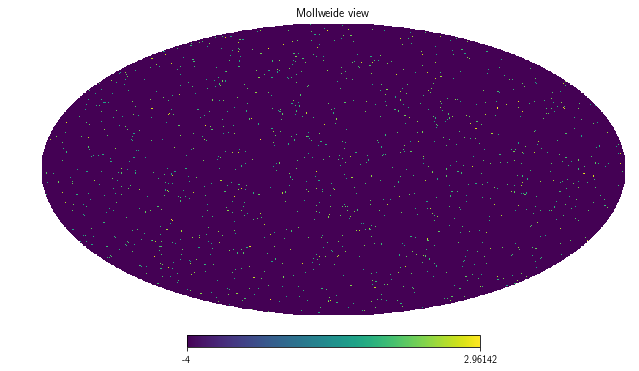

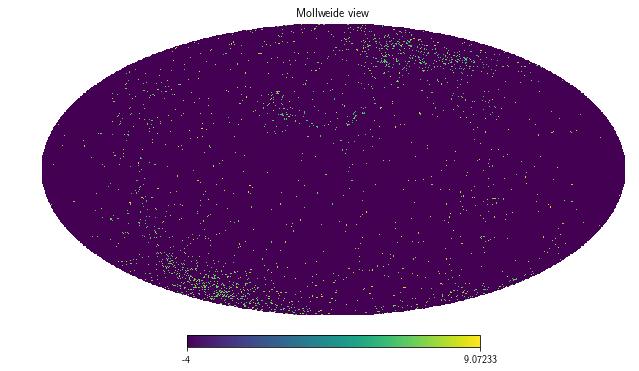

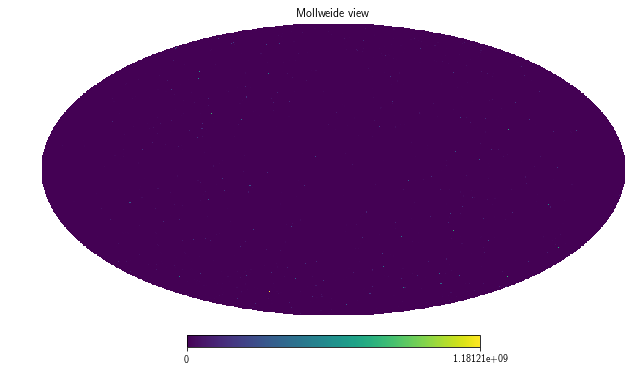

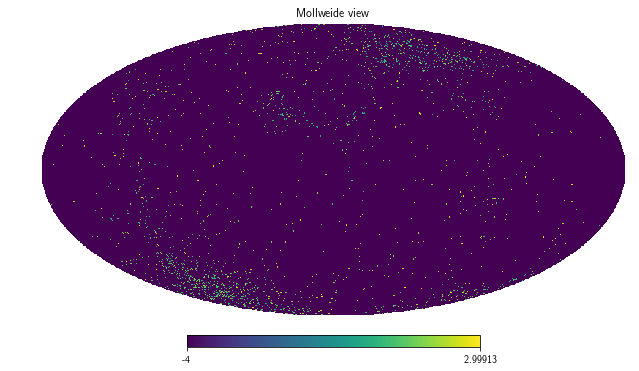

In [8]:
hp.mollview(np.log10(1e-4+np.load("EnergyBins/BlazarsTests/MPITemp/fake_data0_test.npy")))
hp.mollview(np.log10(1e-4+np.load("EnergyBins/BlazarsTests/subs.npy")))
hp.mollview(np.load("EnergyBins/BlazarsTests/subs.npy"))
hp.mollview(np.log10(1e-4+np.load("EnergyBins/BlazarsTests/MPITemp/fake_data0__VL_NBkg_1.487352107293512e-20_0_siginj_.npy")))

In [5]:
SCD_params_arr = [
    np.array([-5.41424955e+00, 2.17210435e+00, 1.67422471e+00, 1.21940734e+00, 6.11800503e+01, 5.31244704e-02 ]),
    np.array([ -4.98619637477781 , 2.24016924 , 1.36771901 , 0.598503459 , 106.0815055 , 0.06800803089999999 ]),
    np.array([ -5.066038999192546 , 2.3051384099999996 , 1.30267301 , 0.2820041945 , 140.805936 , 0.0434402163 ]),
    np.array([ -4.76502241 , 2.22269868 , 1.14546229 , 0.125770298 , 124.07591 , 0.0570153848 ]),
    np.array([ -4.57571879 , 2.05 , 1.03360119 , -0.374956899 , 86.4358784 , 0.0592700589 ]),
    np.array([ -4.57134424 , 2.05 , 0.957247191 , -0.752547573 , 97.4831177 , 0.057703257 ]),
    np.array([ -4.51326846 , 2.05 , 0.835773901 , -1.03445536 , 97.8904608 , 0.0632892776 ]),
    np.array([ -4.5594701 , 2.05820366 , 0.754631227 , -1.68317832 , 114.956968 , 0.0595772847 ]),
    np.array([ -4.54236738 , 2.07019124 , 0.632113389 , -1.32596527 , 125.187277 , 0.071898825 ]),
    np.array([ -4.55208903 , 2.07045348 , 0.521428991 , -1.39704795 , 137.859196 , 0.0823514823 ]),
    np.array([ -4.59654015 , 2.12875567 , 0.425414999 , -1.3690295 , 159.795016 , 0.0914130897 ]),
    np.array([ -4.61134188 , 2.13100741 , 0.245861525 , -1.38036074 , 172.009221 , 0.103224933 ]),
    np.array([ -4.59718001 , 2.0990278 , 0.0593279958 , -1.33383551 , 176.63565 , 0.117649574 ]),
    np.array([ -4.58431185 , 2.06655174 , -0.549765447 , -0.56790069 , 170.16068346 , 0.77286879 ]),
    np.array([ -4.63732532 , 2.05031271 , -0.857080848 , -0.68655096 , 184.244227 , 0.81489157 ]),
    np.array([ -4.68435333 , 2.06245759 , -1.47686807 , -0.89002684 , 186.42380448 , 0.83344079 ]),
    np.array([ -4.714422515649848 , 2.05 , -1.572507775 , -1.443929775 , 183.09088777 , 0.8553081505 ]),
    np.array([ -4.8692431 , 2.05007773 , -0.74783313 , -1.62840241 , 215.00913456 , 1.0 ]),
    np.array([ -4.990738263317503 , 2.0500000050000002 , -0.61566255 , -2.58494543 , 217.56453428999998 , 1.0 ]),
    np.array([ -5.14560829 , 2.08266773 , 0.229910002 , -3.22390323 , 247.07739611 , 1.0 ]),
    np.array([ -5.30171833 , 2.0566429 , 0.61784026 , -4.28141848 , 253.63927277 , 1.0 ]),
    np.array([ -5.52372047 , 2.17015404 , -0.57010827 , -6.02989334 , 290.31426569 , 1.0 ]),
    np.array([ -5.719179252641322 , 2.0947778699999997 , 0.54204283 , -9.313187500000002 , 279.28840021999997 , 1.0 ]),
    np.array([ -5.9755476396314595 , 2.0929481699999997 , 0.312241114 , -10.0 , 290.06401884 , 1.0 ]),
    np.array([ -6.28815968 , 2.05901097 , -0.237665732 , -10.0 , 289.02456454 , 1.0 ]),
    np.array([ -6.6821251451281505 , 2.05 , -1.5401008900000002 , -10.0 , 275.254589945 , 1.0 ]),
    np.array([ -7.2309346 , 2.05 , -2.69479712 , -10.0 , 300.12239076 , 1.0 ])
]

SCD_params_xsec = np.array([
    1e-22,
    1e-21 ,
    1.4125375446227497e-21 ,
    1.9952623149688665e-21 ,
    2.818382931264449e-21 ,
    3.981071705534986e-21 ,
    5.6234132519034906e-21 ,
    7.943282347242789e-21 ,
    1.1220184543019562e-20 ,
    1.5848931924611108e-20 ,
    2.238721138568347e-20 ,
    3.162277660168379e-20 ,
    4.4668359215096164e-20 ,
    6.309573444801891e-20 ,
    8.912509381337441e-20 ,
    1.2589254117941713e-19 ,
    1.7782794100389227e-19 ,
    2.5118864315095717e-19 ,
    3.548133892335731e-19 ,
    5.011872336272715e-19 ,
    7.079457843841402e-19 ,
    1e-18 ,
    1.4125375446227497e-18 ,
    1.9952623149688666e-18 ,
    2.818382931264449e-18 ,
    3.981071705534985e-18 ,
    5.623413251903491e-18
])

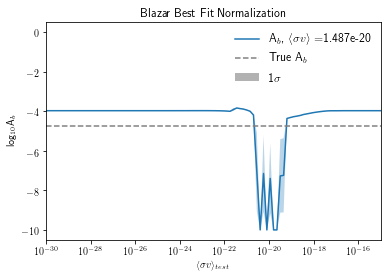

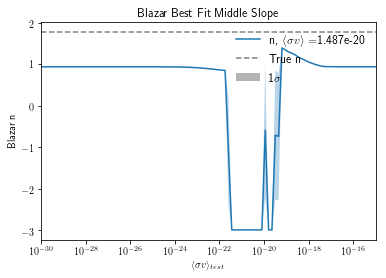

In [40]:
tag1 = "_IsoBlazarsFBlaz"
tag2 = "IsoBlazMidBreak_NOTTHIS"
#tag1 = "BlazNorm"
#tag2 = "BlazFBlazNorm_NOTTHIS"

best_fit_params = []
xi_arr = [29]
# Ab_arr = []
# for xi in xi_arr:
#     best_fit_params.append([])
#     for t in range(5):
#         Ab_arr_xsec = []
#         for i in range(20):
#             if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
#                 Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,0])
#             if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
#                 Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,0])
#         if Ab_arr_xsec != []: Ab_arr.append(np.array(Ab_arr_xsec))
#         else: Ab_arr_xsec.append(np.zeros(101))
#     p = plt.plot(xsec_test_arr, np.percentile(Ab_arr, 50, axis=0), label="A, $\\langle \sigma v \\rangle=$"+'{:0.3e}'.format(xsec_inj[xi]))
#     best_fit_params[int(xi/25)].append(np.percentile(Ab_arr, 50, axis=0)[xi])
#     plt.fill_between(xsec_test_arr, np.percentile(Ab_arr, 16, axis=0), np.percentile(Ab_arr, 84, axis=0), facecolor=p[0].get_color(), alpha=0.3)
# plt.fill_between([-100], [0], [0], label="1$\sigma$", facecolor="black", alpha=0.3)
# #plt.ylim(0.875, 0.95)
# plt.xlim(1e-30, 1e-20)
# #plt.axhline(0.89989243, ls="--", c="grey", label="True A")
# #plt.axhline(0.14331159, ls="--", c="grey", label="True A")
# plt.xscale("log")
# plt.ylabel("log$_{10}$A")
# plt.title("Blazar Best Fit Normalization")
# plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
# plt.legend(frameon=False, loc=1, fontsize=12)
# plt.show()
# plt.close()

# best_fit_params = []
# Ab_arr = []
# for xi in xi_arr:
#     best_fit_params.append([])
#     for t in range(5):
#         Ab_arr_xsec = []
#         for i in range(20):
#             if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
#                 Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,1])
#             if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
#                 Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,1])
#         if Ab_arr_xsec != []: Ab_arr.append(np.array(Ab_arr_xsec))
#         else: Ab_arr_xsec.append(np.zeros(101))
#     p = plt.plot(xsec_test_arr, np.percentile(Ab_arr, 50, axis=0), label="A, $\\langle \sigma v \\rangle=$"+'{:0.3e}'.format(xsec_inj[xi]))
#     best_fit_params[int(xi/25)].append(np.percentile(Ab_arr, 50, axis=0)[xi])
#     plt.fill_between(xsec_test_arr, np.percentile(Ab_arr, 16, axis=0), np.percentile(Ab_arr, 84, axis=0), facecolor=p[0].get_color(), alpha=0.3)
# plt.fill_between([-100], [0], [0], label="1$\sigma$", facecolor="black", alpha=0.3)
# #plt.ylim(10, 1e3)
# plt.yscale("log")
# plt.xlim(1e-22, 1e-18)
# #plt.axhline(0.89989243, ls="--", c="grey", label="True A")
# #plt.axhline(0.14331159, ls="--", c="grey", label="True A")
# plt.xscale("log")
# plt.ylabel("log$_{10}$A")
# plt.title("Isotropic Best Fit Normalization")
# plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
# plt.legend(frameon=False, loc=1, fontsize=12)
# plt.show()
# plt.close()


Ab_arr = []
for xi in xi_arr:
    best_fit_params.append([])
    for t in range(5):
        Ab_arr_xsec = []
        for i in range(20):
            if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
                Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,0])
            if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
                Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,0])
        if Ab_arr_xsec != []: Ab_arr.append(-2-np.array(Ab_arr_xsec))
        else: Ab_arr_xsec.append(np.zeros(101))
    p = plt.plot(xsec_test_arr, np.percentile(Ab_arr, 50, axis=0), label="A$_{b}$, $\\langle \sigma v \\rangle=$"+'{:0.3e}'.format(xsec_inj[xi]))
    best_fit_params[int(xi/40)].append(np.percentile(Ab_arr, 50, axis=0)[xi])
    plt.fill_between(xsec_test_arr, np.percentile(Ab_arr, 16, axis=0), np.percentile(Ab_arr, 84, axis=0), facecolor=p[0].get_color(), alpha=0.3)
plt.fill_between([-100], [0], [0], label="1$\sigma$", facecolor="black", alpha=0.3)
#plt.ylim(-7, -4)
plt.xlim(1e-30, 1e-15)
plt.axhline(-4.733327518453883, ls="--", c="grey", label="True A$_b$")
plt.xscale("log")
plt.ylabel("log$_{10}$A$_{b}$")
plt.title("Blazar Best Fit Normalization")
plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
plt.legend(frameon=False, loc=1, fontsize=12)
plt.show()
plt.close()

Ab_arr = []
for xi in xi_arr:
    for t in range(5):
        Ab_arr_xsec = []
        for i in range(20):
            if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
                Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag1+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,1])
            if os.path.exists('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy'):
                Ab_arr_xsec.extend(np.load('/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/MPITemp/SCDb_'+str(i)+'_'+tag2+'_'+str(xsec_inj[xi])+'_'+str(t)+'_siginj_.npy')[:,0,1])

            if len(Ab_arr_xsec)==101: Ab_arr.append(-3+np.array(Ab_arr_xsec))
        else: Ab_arr_xsec.append(np.zeros(101))
    p = plt.plot(xsec_test_arr, np.percentile(Ab_arr, 50, axis=0), label="n, $\\langle \sigma v \\rangle=$"+'{:0.3e}'.format(xsec_inj[xi]))
    #best_fit_params[int(xi/25)].append(np.percentile(Ab_arr, 50, axis=0)[xi])
    plt.fill_between(xsec_test_arr, np.percentile(Ab_arr, 16, axis=0), np.percentile(Ab_arr, 84, axis=0), facecolor=p[0].get_color(), alpha=0.3)
plt.fill_between([-100], [0], [0], label="1$\sigma$", facecolor="black", alpha=0.3)
plt.xscale("log")
plt.xlim(1e-30, 1e-15)
plt.axhline(1.77293727, ls="--", c="grey", label="True n")
#plt.axhline(2.4461263, ls="--", c="grey", label="True n")
#plt.ylim(1.55, 2.0)
#plt.ylim(1.5, 2.)
plt.ylabel("Blazar n")
plt.title("Blazar Best Fit Middle Slope")
plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
plt.legend(frameon=False, loc=1, fontsize=12)
plt.show()
plt.close()

In [45]:
plt.plot(subs_inj, TS_max_ave, c="red")
plt.fill_between(subs_inj, TS_max_1stdd, TS_max_1stdu, facecolor="red", alpha=0.3)
plt.yscale("log")
#ax2.set_xscale("log")
plt.xlim(1,100)
plt.ylim(1e-3, 1e3)
plt.ylabel("$TS_{max}$")

NameError: name 'subs_inj' is not defined

In [ ]:
mass_arr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])
# mass_arr2 = []
# for im in range(len(mass_arr)):
#     if im%3==0: mass_arr2.append(mass_arr[im])
# mass_arr = np.array(mass_arr2)
# print(mass_arr)
#mass_arr = np.array([4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])
ll_ary = []
xsec_rec = []
xsec_rec_dir = ''
for i in mass_arr:
    xsec_rec.append([])
for file in os.listdir(xsec_rec_dir):
    if ".npz" not in file: continue
    mass = float(re.findall(r'lim_5_[\d+]?[.]?\d+.\d+', file)[0][6:])
    if mass == 100: ll_ary.append(np.load(xsec_rec_dir+file)['arr_1'])
    if mass in mass_arr: xsec_rec[ np.argmax(mass_arr == mass) ].append(np.load(xsec_rec_dir+file)['arr_0'][0])
xsec_rec_ave = []
xsec_rec_1stdu = []
xsec_rec_1stdd = []
xsec_rec_2stdu = []
xsec_rec_2stdd = []
for i in range(len(xsec_rec)):
    xsec_rec[i] = np.array(xsec_rec[i])
    if len(xsec_rec[i])==0: 
        xsec_rec_ave.append(0)
        xsec_rec_1stdu.append(0)
        xsec_rec_1stdd.append(0)
        xsec_rec_2stdu.append(0)
        xsec_rec_2stdd.append(0)
        continue
    xsec_rec_ave.append(np.percentile(xsec_rec[i], 50))
    xsec_rec_1stdu.append(np.percentile(xsec_rec[i], 84))
    xsec_rec_1stdd.append(np.percentile(xsec_rec[i], 16))
    xsec_rec_2stdu.append(np.percentile(xsec_rec[i], 97.5))
    xsec_rec_2stdd.append(np.percentile(xsec_rec[i], 2.5))

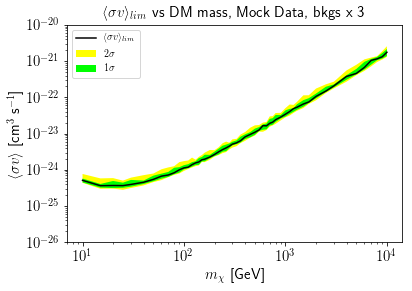

In [26]:
from matplotlib import rc
rc('text', usetex=True)
fig, ax = plt.subplots()
plt.plot((mass_arr), (xsec_rec_ave), label="$\\langle \\sigma v \\rangle_{lim}$", c="black")
plt.fill_between((mass_arr), (xsec_rec_2stdd), (xsec_rec_2stdu), label="$2 \\sigma$", facecolor="yellow")
plt.fill_between((mass_arr), (xsec_rec_1stdd), (xsec_rec_1stdu), label="$1 \\sigma$", facecolor="lime")
#plt.axhline(2.310129700083158e-24,ls='--')
plt.ylim(1e-26, 1e-20)
#plt.xlim(200,300)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=10, loc=2)
plt.xlabel("$m_{\chi}$ [GeV]", fontsize=15)
plt.ylabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.title("$\\langle \\sigma v \\rangle_{lim}$ vs DM mass, Mock Data, bkgs x 3", fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);

In [83]:
xsec_test_arr = np.logspace(-30, -18, 101)
ll_ave = []
ll_1stdu = []
ll_1stdd = []
ll_2stdu = []
ll_2stdd = []
for il in range(len(ll_ary[:1])):
    il2 = 43
    ll_ary2 = 2*(ll_ary[il2] - ll_ary[il2][0][0])
    #plt.plot(xsec_test_arr, ll_ary2[il])
    if ll_ary2 == []:
        ll_ave.append(np.zeros(101))
        ll_1stdu.append(np.zeros(101))
        ll_1stdd.append(np.zeros(101))
        ll_2stdu.append(np.zeros(101))
        ll_2stdd.append(np.zeros(101))
        continue
    ll_ave.append(np.percentile(ll_ary2, 50, axis=0))
    ll_1stdu.append(np.percentile(ll_ary2, 84, axis=0))
    ll_1stdd.append(np.percentile(ll_ary2, 16, axis=0))
    ll_2stdu.append(np.percentile(ll_ary2, 97.5, axis=0))
    ll_2stdd.append(np.percentile(ll_ary2, 2.5, axis=0))

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


84
1.2022644346174083e-20
3109.9651566012035


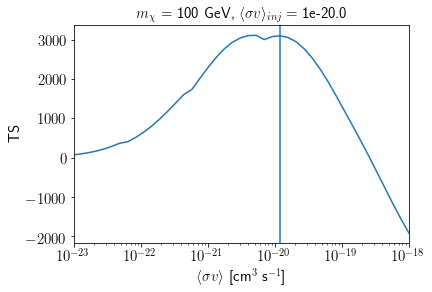

In [117]:
fig, ax = plt.subplots()
for il in range(len(ll_ave)):
    ll_ave[il] = np.array(ll_ave[il])
    for iil, l in enumerate(ll_ave[il][1:-1]):
        if np.abs(ll_ave[il][iil]/ll_ave[il][iil-1]) > 2: 
            ll_ave[il][iil] = (ll_ave[il][iil-1]+ll_ave[il][iil+1])/2.
            ll_2stdd[il][iil] = (ll_2stdd[il][iil-1] + ll_2stdd[il][iil+1])/2.
            ll_2stdu[il][iil] = (ll_2stdu[il][iil-1] + ll_2stdu[il][iil+1])/2.
            ll_1stdd[il][iil] = (ll_1stdd[il][iil-1] + ll_1stdd[il][iil+1])/2.
            ll_1stdu[il][iil] = (ll_1stdu[il][iil-1] + ll_1stdu[il][iil+1])/2.
    plt.plot(xsec_test_arr, ll_ave[il], label="Mean TS")
    #p2 = np.poly1d(np.polyfit(xsec_test_arr, 2*(ll_ave[il]-(ll_ave[il][0])), 2, w=2./(np.array(ll_1stdu[il])-np.array(ll_1stdd[il]))))
    #plt.plot(xsec_test_arr, p2(xsec_test_arr))
    plt.fill_between(xsec_test_arr, ll_2stdd[il], ll_2stdu[il], facecolor="yellow", label="$2 \\sigma$")
    plt.fill_between(xsec_test_arr, ll_1stdd[il], ll_1stdu[il], facecolor="limegreen", label="$1 \\sigma$")
#plt.yscale("log")
plt.xscale("log")
#plt.ylim(3e13,6e13)
plt.xlim(1e-23, 1e-18)
plt.axvline(xsec_test_arr[np.argmax(ll_ave[il])+1+np.argmax(ll_ave[il][np.argmax(ll_ave[il])+1:])])
print(np.argmax(ll_ave[il])+1+np.argmax(ll_ave[il][np.argmax(ll_ave[il])+1:]))
print(xsec_test_arr[np.argmax(ll_ave[il])+1+np.argmax(ll_ave[il][np.argmax(ll_ave[il])+1:])])
print(max(ll_ave[il])+1+np.argmax(ll_ave[il][np.argmax(ll_ave[il])+1:]))
plt.title("$m_{\chi}$ = 100 GeV, $\\langle \\sigma v \\rangle_{inj} = $ 1e"+str(round(np.log10(xsec_inj[il2]), 2)), fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.ylabel("TS", fontsize = 15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);
#plt.legend(fontsize=15)
#plt.ylim(-423500, -421500)
#plt.ylim(-300, 500)

ValueError: x and y must have same first dimension, but have shapes (51,) and (101,)

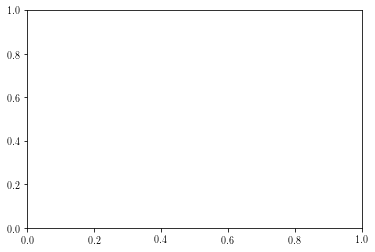

In [24]:
d_arr = []
i_arr = []
p_arr = []
limdir = "EnergyBins/lim/101520idp/"
xsec_rec = 0
n=0
for ib in [0, 1]:
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "0.0" in file:
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
    # d = 0.9095
    # i = 0.0862
    # p = 0.03719

    if ib == 0:
        d_n =  0.8999
        i_n =  0.1433
        p_n =  0.03794
    if ib == 1:
        d_n =   0.9784
        i_n =  0.02912
        p_n =  0.02612   

    #d = 13.9583217
    #i = 1.06289421
    #p = 0.90448092
    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
    plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
    plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
    plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-.3, .2)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{0.0}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

    d_arr = []
    i_arr = []
    p_arr = []
    xsec_rec = 0
    n=0
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "1e-23" in file: 
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
            xsec_rec += np.load(limdir+file)['arr_0'][0]

    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
    plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
    plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
    plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-.3, .2)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{1e-23}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

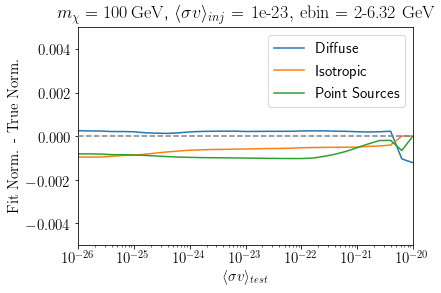

In [122]:
d_arr = []
i_arr = []
p_arr = []
limdir = "EnergyBins/lim/101520idp/"
xsec_rec = 0
n=0
for ib in [0]:
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "0.0" in file:
            d_arr.append([])
            i_arr.append([])
            p_arr.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr[-1].append(np.load(limdir+file)['arr_4'][i][0])
    # d = 0.9095
    # i = 0.0862
    # p = 0.03719

    if ib == 0:
        d_n =  0.8999
        i_n =  0.1433
        p_n =  0.03794
    if ib == 1:
        d_n =   0.9784
        i_n =  0.02912
        p_n =  0.02612   

    #d = 13.9583217
    #i = 1.06289421
    #p = 0.90448092
#     plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)-d_n, label="Diffuse")
#     plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)-d_n, np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
#     plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)-i_n, label="Isotropic")
#     plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
#     plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)-p_n, label="Point Sources")
#     plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
#     plt.xscale("log")
#     plt.xlim(1e-26, 1e-20)
#     plt.axhline(0,ls='--', zorder=10, c="grey")
#     plt.ylim(-.3, .2)
#     plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
#     plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
#     plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{0.0}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
#     plt.legend()

    d_arr2 = []
    i_arr2 = []
    p_arr2 = []
    xsec_rec = 0
    n=0
    for file in os.listdir(limdir):
        n+=1
        #if "1e-23" in file: 
        if "1e-23" in file: 
            d_arr2.append([])
            i_arr2.append([])
            p_arr2.append([])
            for i in range(len(np.load(limdir+file)['arr_2'])):
                if i%2 == ib: 
                    d_arr2[-1].append(np.load(limdir+file)['arr_2'][i][0])
                    i_arr2[-1].append(np.load(limdir+file)['arr_3'][i][0])
                    p_arr2[-1].append(np.load(limdir+file)['arr_4'][i][0])
            xsec_rec += np.load(limdir+file)['arr_0'][0]

    plt.plot(xsec_test_arr, np.percentile(d_arr, 50, axis=0)- np.percentile(d_arr2, 50, axis=0), label="Diffuse")
    #plt.fill_between(xsec_test_arr, np.percentile(d_arr, 16, axis=0)- np.percentile(d_arr, 50, axis=0), np.percentile(d_arr, 84, axis=0)-d_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(i_arr, 50, axis=0)- np.percentile(i_arr2, 50, axis=0), label="Isotropic")
    #plt.fill_between(xsec_test_arr, np.percentile(i_arr, 16, axis=0)-i_n, np.percentile(i_arr, 84, axis=0)-i_n, alpha=0.3)
    plt.plot(xsec_test_arr, np.percentile(p_arr, 50, axis=0)- np.percentile(p_arr2, 50, axis=0), label="Point Sources")
    #plt.fill_between(xsec_test_arr, np.percentile(p_arr, 16, axis=0)-p_n, np.percentile(p_arr, 84, axis=0)-p_n, alpha=0.3)
    plt.xscale("log")
    plt.xlim(1e-26, 1e-20)
    plt.axhline(0,ls='--', zorder=10, c="grey")
    plt.ylim(-5e-3, 5e-3)
    plt.xlabel("$\\langle \\sigma v \\rangle_{test}$")
    plt.ylabel("$\\textrm{Fit Norm. - True Norm.}$")
    plt.title("$m_{\\chi} = 100\, \\textrm{GeV}$, $\\langle \\sigma v \\rangle_{inj} =\, \\textrm{1e-23}, \, \\textrm{ebin = "+["2-6.32 GeV", "6.32-20 GeV"][ib]+"}$")
    plt.legend()
    plt.show()
    plt.close()

In [227]:
args_arr = [ [ True, False, True, 5e-24, 10, 15 ],
             [ False, False, True, 5e-24, 10, 15 ],                                               
             [ True, False, True, 1e-25, 10, 15 ],
             [ False, False, True, 1e-25, 10, 15 ],                                                 
             [ True, False, True, 1e-24, 10, 15 ],
             [ False, False, True, 1e-24, 10, 15 ],                                                 
             [ True, False,  True, 1e-23, 10, 15 ],
             [ False, False,  True, 1e-23, 10, 15 ],                                                
             [ True, False, True, 1e-22, 10, 15 ],
             [ False, False, True, 1e-22, 10, 15 ]                                                 
#             [ True, False, True, 1e-24, 15, 20 ],
#             [ False, False, True, 1e-24, 15, 20 ],                                                 
#             [ True, False,  True, 1e-23, 15, 20 ],
#             [ False, False,  True, 1e-23, 15, 20 ],                                                 
#             [ True, False, True, 1e-22, 15, 20 ],
#            [ False, False, True, 1e-22, 15, 20 ] 
           ]

args_arr = []
#xsec_inj_arr = np.logspace(-25, -21, 20)
#xsec_inj_arr = np.logspace(-26, -19, 10)
xsec_inj_arr = np.logspace(-24, -22, 10)

for xsec in xsec_inj_arr:
    args_arr.append( [ True, False, True, xsec, 10, 15 ] )
    args_arr.append( [ False, False, True, xsec, 10, 15 ] )

ll_floatsig = [ [] for i in range(len(xsec_inj_arr))]
ll_floatiso = [ [] for i in range(len(xsec_inj_arr))]

for floatsig, poiss, minuit, xsec_inj, ebin1, ebin2 in args_arr:
    ave = []
    ix = np.argmin(np.abs(xsec_inj-xsec_inj_arr))
    for trial in range(10):
        tag = "9"+str(floatsig) + "_" + str(poiss) + "_" + str(minuit) + "_" + str(xsec_inj) + "_" + str(ebin1) + "_" + str(ebin2) + "_" + str(trial)
        try: 
            f = open("EnergyBins/BlazarsTests/slurm/slurm"+tag+".out", "r")
            for line in f:
                pass
            try:    
                #if float(line) > 1e4: continue
                ave.append(float(line))
            except: 
                ave.append(100000)
        except: 
            ave.append(100000)
        if floatsig: ll_floatsig[ix] = ave
        else: ll_floatiso[ix] = ave
#     if floatsig and ave != []: 
#         ll_floatsig[ix] = (np.median(ave))
#         ll_floatsig_1stdu[ix] = (np.percentile(ave, 84))
#         ll_floatsig_1stdd[ix] = (np.percentile(ave, 16))
#     elif floatsig and ave == []: 
#         ll_floatsig[ix] = (-np.inf)
#         ll_floatsig_1stdu[ix] = (-np.inf)
#         ll_floatsig_1stdd[ix] = (-np.inf)
#     elif (not floatsig) and ave != []:
#         ll_floatiso[ix] = (np.median(ave))
#         ll_floatiso_1stdu[ix] = (np.percentile(ave, 84))
#         ll_floatiso_1stdd[ix] = (np.percentile(ave, 16))
#     elif (not floatsig) and ave == []:
#         ll_floatiso[ix] = (-np.inf)
#         ll_floatiso_1stdu[ix] = (-np.inf)
#         ll_floatiso_1stdd[ix] = (-np.inf)

No handles with labels found to put in legend.


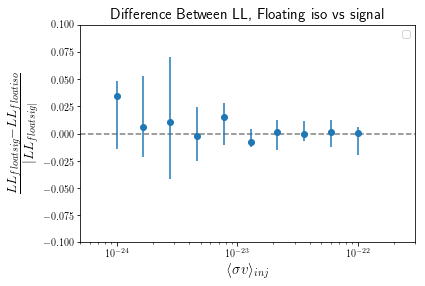

In [228]:
axes = plt.gca()
dif = [ [] for i in range(len(xsec_inj_arr))]
for i in range(len(xsec_inj_arr)):
    for j in range(len(ll_floatsig[i])):
        if ll_floatsig[i][j] < 1e5 and ll_floatiso[i][j] < 1e5:
            #if i > 6: print(ll_floatsig[i][j], ll_floatiso[i][j])
            dif[i].append((np.array(ll_floatsig[i][j]) - np.array(ll_floatiso[i][j]))/np.abs(ll_floatsig[i][j]))
dif_med = []
dif_1stdd = []
dif_1stdu = []
for d in dif:
    if d == []: 
        dif_med.append(10000)
        dif_1stdu.append(10000)
        dif_1stdd.append(10000)
        continue
    dif_med.append(np.percentile(d, 50, axis=0))
    dif_1stdu.append(np.percentile(d, 84, axis=0))
    dif_1stdd.append(np.percentile(d, 16, axis=0))
    
dif_med = np.array(dif_med)
dif_1stdd = dif_med - np.array(dif_1stdd)
dif_1stdu = np.array(dif_1stdu) - dif_med

plt.errorbar(xsec_inj_arr, dif_med, yerr = [dif_1stdd, dif_1stdu], fmt="o")
#for d in range(len(dif)):
    #plt.scatter(xsec_inj_arr[d]*np.ones(len(dif[d])), dif[d])
    #print(dif[d])
#plt.scatter( xsec_inj_arr, dif_med, label="MC" )
axes.set_xscale('log')
axes.set_xlim(5e-25, 3e-22)
axes.set_ylim(-.1,.1)
ylim = axes.get_ylim()
axes.axhline(0, ls='--', c='grey', zorder=0)
plt.ylabel("$\\frac{LL_{float sig} - LL_{float iso}}{|LL_{float sig|}}$", fontsize=20)
#plt.ylabel("$LL_{float sig} - LL_{float iso}$", fontsize=15)
plt.xlabel("$\langle \\sigma v \\rangle_{inj}$", fontsize=15)
plt.title("Difference Between LL, Floating iso vs signal", fontsize=15)
plt.legend()

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


(2000, 9909.246373563006)

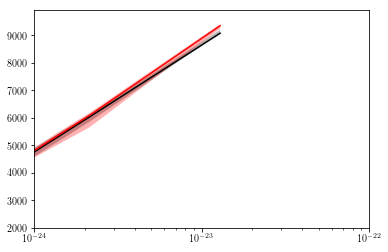

In [53]:
for i in range(len(ll_floatsig)):
    for j in range(len(ll_floatsig[j])):
        if ll_floatsig[i][j] > 1e4: ll_floatsig[i][j] = np.nan
        if ll_floatiso[i][j] > 1e4: ll_floatiso[i][j] = np.nan
median = np.nanpercentile(ll_floatsig, 50, axis=1)
stdu = np.nanpercentile(ll_floatsig, 84, axis=1)
stdd = np.nanpercentile(ll_floatsig, 16, axis=1)
plt.plot(xsec_inj_arr, median[0]-median, c="black")
plt.fill_between(xsec_inj_arr, median[0]-stdd, median[0]-stdu, alpha=0.3, facecolor="black")

median = np.nanpercentile(ll_floatiso, 50, axis=1)
stdu = np.nanpercentile(ll_floatiso, 84, axis=1)
stdd = np.nanpercentile(ll_floatiso, 16, axis=1)
plt.plot(xsec_inj_arr, median[0]-median, c="red")
plt.fill_between(xsec_inj_arr, median[0]-stdd, median[0]-stdu, alpha=0.3, facecolor="red")

plt.xscale('log')
plt.xlim(1e-24, 1e-22)
plt.ylim(2000)

In [70]:
dNdLogx_df = pd.read_csv('/tigress/somalwar/Subhaloes/Subhalos/Data/AtProduction_gammas.dat', delim_whitespace=True)
DMmass = 100
channel = 'b'

dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(DMmass)))))[['Log[10,x]',channel]]
Egamma = np.array(DMmass*(10**dNdLogx_ann_df['Log[10,x]']))
dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
dNdE_interpd = interp1d(Egamma, dNdEgamma)

Text(0,0.5,'dN/dE')

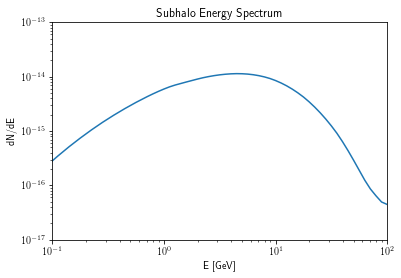

In [75]:
plt.plot(Egamma, 3e-26 * 5051686543933324.0 / ( 8*np.pi*100**2) * Egamma**2 * dNdEgamma)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-1, 1e2)
plt.ylim(1e-17, 1e-13)
plt.title("Subhalo Energy Spectrum")
plt.xlabel("E [GeV]")
plt.ylabel("dN/dE")

In [104]:
xsec_arr = []
xsec_rec = []
SCD_rec = []
for i in [ 0, 19, 3, 8 ]:
    xsec_arr.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_faster_1e-23_"+str(i)+"_siginj_.npz")['arr_1'])
    xsec_rec.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_faster_1e-23_"+str(i)+"_siginj_.npz")['arr_0'])
    SCD_rec.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_faster_1e-23_"+str(i)+"_siginj_.npz")['arr_2'])

In [90]:
xsec_arr = []
xsec_rec = []
SCD_rec = []
for i in [ 11, 13, 14, 16, 18, 19, 2, 4, 5, 6, 8, 9 ]:
    xsec_arr.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_mpi_1e-23_"+str(i)+"_siginj_.npz")['arr_1'])
    xsec_rec.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_mpi_1e-23_"+str(i)+"_siginj_.npz")['arr_0'])
    SCD_rec.append(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/lim_1e-23_mpi_1e-23_"+str(i)+"_siginj_.npz")['arr_2'])

In [105]:
print(xsec_rec)

[array([ 6.98032255e-25, -6.11196932e+04]), array([ 1.36247475e-24, -6.13628254e+04]), array([ 1.01591878e-24, -6.16143817e+04]), array([ 1.27612882e-24, -6.07070669e+04])]


[1.00000000e-28 2.51188643e-28 6.30957344e-28 1.58489319e-27
 3.98107171e-27 1.00000000e-26 2.51188643e-26 6.30957344e-26
 1.58489319e-25 3.98107171e-25 1.00000000e-24 2.51188643e-24
 6.30957344e-24 1.58489319e-23 3.98107171e-23 1.00000000e-22
 2.51188643e-22 6.30957344e-22 1.58489319e-21 3.98107171e-21
 1.00000000e-20]


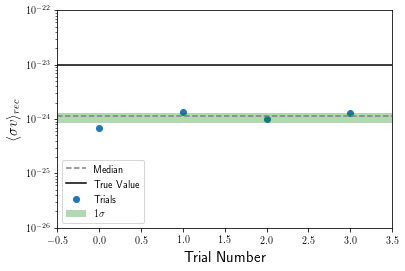

In [106]:
xsec_rec=np.array(xsec_rec)
plt.scatter(range(len(xsec_rec)), np.array(xsec_rec)[:,0], label="Trials")
plt.yscale("log")
print(np.logspace(-28, -20, 21))
plt.ylim(1e-26, 1e-22)
plt.axhline(np.percentile(xsec_rec[:,0], 50), c="grey", ls="--", label="Median")
plt.fill_between([-5,5,10], np.ones(3)*np.percentile(xsec_rec[:,0], 16), np.ones(3)*np.percentile(xsec_rec[:,0], 84), facecolor="green", alpha=0.3, label="$1\\sigma$")
plt.axhline(1e-23, label="True Value", c="black")
plt.xlabel("Trial Number", fontsize=15)
plt.ylabel("$\\langle \\sigma v \\rangle_{rec}$", fontsize=15)
plt.xlim(-.5,3.5)
plt.legend()

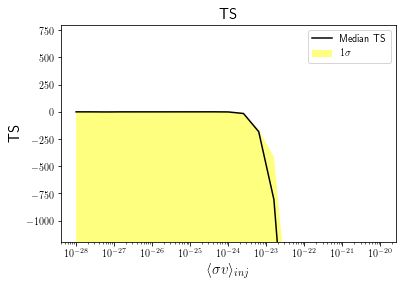

In [111]:
TS_arr = []
for ll in xsec_arr:
    TS_arr.append(2*(ll-ll[0]))
xsec_test = np.logspace(-28, -20, 21)
plt.plot(xsec_test, np.percentile(TS_arr, 50, axis=0), c='black', label="Median TS")
plt.fill_between(xsec_test, np.percentile(TS_arr, 16), np.percentile(TS_arr, 84, axis=0), facecolor="yellow", alpha=0.5, label="$1\\sigma$")
plt.xscale("log")
plt.ylim(-12e2,8e2)
plt.ylabel("TS", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$", fontsize=15)
plt.title("TS", fontsize=15)
plt.legend()

In [18]:
A_rec = []
n1_rec = []
n2_rec = []
n3_rec = []
Fb1_rec = []
Fb2_rec = []
for i in range(len(SCD_rec)):
    A_temp = []
    n1_temp = []
    n2_temp = []
    n3_temp = []
    Fb1_temp = []
    Fb2_temp = []
    for j in range(len(SCD_rec[i])):
        A_temp.append((SCD_rec[i][j][0][0]))
        n1_temp.append((SCD_rec[i][j][0][1]))
        n2_temp.append((SCD_rec[i][j][0][2]))
        n3_temp.append((SCD_rec[i][j][0][3]))
        Fb1_temp.append((SCD_rec[i][j][0][4]))
        Fb2_temp.append((SCD_rec[i][j][0][5])*SCD_rec[i][j][0][4])
    A_rec.append(A_temp)
    n1_rec.append(n1_temp)
    n2_rec.append(n2_temp)
    n3_rec.append(n3_temp)
    Fb1_rec.append(Fb1_temp)
    Fb2_rec.append(Fb2_temp)
A_rec = np.array(A_rec)
n1_rec = np.array(n1_rec)
n2_rec = np.array(n2_rec)
n3_rec = np.array(n3_rec)
Fb1_rec = np.array(Fb1_rec)
Fb2_rec = np.array(Fb2_rec)
xsec_inj = np.logspace(-28, -20, 21)
plt.plot(xsec_inj, np.percentile(A_rec, 50, axis=0), c="black")
plt.fill_between(xsec_inj, np.percentile(A_rec, 16, axis=0), np.percentile(A_rec, 84, axis=0), facecolor="yellow", alpha=0.6)
plt.ylabel("$A_{blaz}$", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$", fontsize=15)
plt.title("Blazar Normalization", fontsize=15)
plt.axvline(np.percentile(xsec_rec[:,0], 50), c="grey", ls="--", label="Best Fit $\\langle \\sigma v \\rangle$")
plt.xscale("log")
plt.legend(fontsize=15)
plt.show()
plt.close()
plt.plot(xsec_inj, np.percentile(n1_rec, 50, axis=0), c="blue")
plt.fill_between(xsec_inj, np.percentile(n1_rec, 16, axis=0), np.percentile(n1_rec, 84, axis=0), facecolor="blue", alpha=0.6, label="$n_1$")
plt.plot(xsec_inj, np.percentile(n2_rec, 50, axis=0), c="green")
plt.fill_between(xsec_inj, np.percentile(n2_rec, 16, axis=0), np.percentile(n2_rec, 84, axis=0), facecolor="green", alpha=0.6, label="$n_2$")
plt.plot(xsec_inj, np.percentile(n3_rec, 50, axis=0), c="orange")
plt.fill_between(xsec_inj, np.percentile(n3_rec, 16, axis=0), np.percentile(n3_rec, 84, axis=0), facecolor="orange", alpha=0.6, label="$n_3$")
plt.axvline(np.percentile(xsec_rec[:,0], 50), c="grey", ls="--", label="Best Fit $\\langle \\sigma v \\rangle$")
plt.ylabel("$n_{blaz}$", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$", fontsize=15)
plt.title("Blazar Slopes", fontsize=15)
plt.xscale("log")
plt.legend(fontsize=15)
plt.show()
plt.close()
plt.plot(xsec_inj, np.percentile(Fb1_rec, 50, axis=0), c="orange")
plt.fill_between(xsec_inj, np.percentile(Fb1_rec, 16, axis=0), np.percentile(Fb1_rec, 84, axis=0), facecolor="orange", alpha=0.6, label="$Fb_2$")
plt.plot(xsec_inj, np.percentile(Fb2_rec, 50, axis=0), c="green")
plt.fill_between(xsec_inj, np.percentile(Fb2_rec, 16, axis=0), np.percentile(Fb2_rec, 84, axis=0), facecolor="green", alpha=0.6, label="$Fb_2$")
plt.axvline(np.percentile(xsec_rec[:,0], 50), c="grey", ls="--", label="Best Fit $\\langle \\sigma v \\rangle$")
plt.ylabel("$Fb_{blaz}$", fontsize=15)
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$", fontsize=15)
plt.title("Blazar Breaks", fontsize=15)
plt.xscale("log")
plt.legend(fontsize=15)
plt.show()
plt.close()

NameError: name 'SCD_rec' is not defined

In [5]:
import re
slurmFolder = "/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/slurm/"
n = 0
arrTot = []
for file in os.listdir(slurmFolder):
    if ".out" not in file and "1e-20" not in file: continue
    num = (float(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", file)[0]))
    if num > 100 or int(num) != num: 
        continue
    for line in open(slurmFolder+file):
        n+=0
    array = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
    for i in range(len(array)):
        array[i] = float(array[i])
    #print(array)
    if len(array)==6:
        arrTot.append(np.array(array))
        n+=1
    else:
        n+=0

KeyboardInterrupt: 

In [22]:
for i in np.logspace(-23, -15, 25):
    print(i)

1e-23
2.154434690031878e-23
4.641588833612792e-23
1e-22
2.154434690031878e-22
4.641588833612792e-22
1e-21
2.154434690031878e-21
4.641588833612791e-21
1e-20
2.154434690031878e-20
4.6415888336127913e-20
1e-19
2.154434690031878e-19
4.641588833612754e-19
1e-18
2.1544346900318778e-18
4.641588833612754e-18
1e-17
2.1544346900318778e-17
4.641588833612753e-17
1e-16
2.154434690031878e-16
4.641588833612773e-16
1e-15


In [158]:
import re
slurmFolder = "/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/slurm/"
xsec_test_arr = np.concatenate((  [1e-22], np.logspace(-20, -12, 25) ))
#xsec_test_arr = np.concatenate((np.logspace(-25, -17, 25)[:6], np.logspace(-23, -15, 25)))
print(xsec_test_arr)
eBins = [ 10, 15, 20, 40 ]
nBins = len(eBins)
for iB in range(nBins-1):
    arrTot_arr_xsec = [[] for i in range(nBins)]
    xsec_arr = []
    SCD_arr = []
    print('------------------------',iB,'---------------------')
    for ix, xsec in enumerate(xsec_test_arr):
        n = 0
        arrTot = []
        for t in range(20):
            try:
                file = "slurm10TeVExactJ_ebins_"+str(int(t))+"_"+str(xsec)+".out"
                nextLine = False
                success = False
                array = []
                strArray = ""
                numBestFit = 0
                for line in open(slurmFolder+file):
                    line = line.rstrip()
                    if "successfully" in line: success = True
                    if "Best Fit Params" in line or nextLine:
                        if "Best Fit Params" in line: numBestFit+=1
                        if "Max LL" in line or numBestFit != 3: 
                            nextLine = False
                            continue
                        else: nextLine = True
                        strArray += line
                array.extend(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", strArray.split("array")[iB+1]))
                if len(array) != 7: 
                    continue
                for i in range(len(array)):
                    array[i] = float(array[i])
                if success:
                    arrTot.append(np.array(array))
                    n+=1
                else:
                    n+=0
            except:
                n+=0
        A_vals = []
        for i in arrTot:
            A_vals.append(10**i[0])
        arrTot_arr_xsec.append( arrTot )
        if np.log10(np.median(A_vals)) == -10 and xsec > 1e-17:
            break
        print(xsec)
        print("np.array([",np.log10(np.median(A_vals)), ", ", np.median(arrTot, axis=0)[1], ",", np.median(arrTot, axis=0)[2], ",", np.median(arrTot, axis=0)[3], ",", np.median(arrTot, axis=0)[4],  ", 1000, ", np.median(arrTot, axis=0)[5], ", ", np.median(arrTot, axis=0)[6], "]),")
        xsec_arr.append(xsec)
        SCD_arr.append([np.log10(np.median(A_vals)), np.median(arrTot, axis=0)[1], np.median(arrTot, axis=0)[2], np.median(arrTot, axis=0)[3], np.median(arrTot, axis=0)[4], 1000, np.median(arrTot, axis=0)[5], np.median(arrTot, axis=0)[6]])
    np.save("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/SCD_arrs/xsec_arr_10000GeVExactJ_ebins_"+str(eBins[iB])+"-"+str(eBins[iB+1]), xsec_arr)
    np.save("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/SCD_arrs/SCD_arr_10000GeVExactJ_ebins_"+str(eBins[iB])+"-"+str(eBins[iB+1]), SCD_arr)

[1.00000000e-22 1.00000000e-20 2.15443469e-20 4.64158883e-20
 1.00000000e-19 2.15443469e-19 4.64158883e-19 1.00000000e-18
 2.15443469e-18 4.64158883e-18 1.00000000e-17 2.15443469e-17
 4.64158883e-17 1.00000000e-16 2.15443469e-16 4.64158883e-16
 1.00000000e-15 2.15443469e-15 4.64158883e-15 1.00000000e-14
 2.15443469e-14 4.64158883e-14 1.00000000e-13 2.15443469e-13
 4.64158883e-13 1.00000000e-12]
------------------------ 0 ---------------------
1e-22
np.array([ -10.0 ,  10.8498872 , -0.913430268 , 3.0 , 1.95 , 1000,  0.05472343 ,  0.01 ]),
1e-20
np.array([ -8.368359777127264 ,  12.881562164999998 , 0.042859915 , 2.27833281 , 1.54824758 , 1000,  0.2991548305 ,  0.0329869 ]),
2.154434690031878e-20
np.array([ -8.013452843545645 ,  14.99999825 , 0.07890219 , 2.202638115 , 1.484116425 , 1000,  0.3 ,  0.023474525 ]),
4.6415888336127913e-20
np.array([ -7.791701541555254 ,  13.3421398 , 0.881845945 , 1.9969465949999998 , 1.420186985 , 1000,  0.29999999850000003 ,  0.022929005 ]),
1e-19
np.array(

In [159]:
xsec = np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/SCD_arrs/xsec_arr_10000GeVExactJ_ebins_10-15.npy")
SCD = np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/BlazarsTests/SCD_arrs/SCD_arr_10000GeVExactJ_ebins_10-15.npy")

In [161]:
print(repr(SCD[np.argmin(np.abs(xsec-4.67e-16))]))
print(repr(SCD[np.argmin(np.abs(xsec-1e-15))]))
print(repr(SCD[np.argmin(np.abs(xsec-1e-20))]))
print(xsec)

array([-5.58916240e+00,  1.50000000e+01,  1.83383485e-01, -1.15322466e+00,
       -1.06555636e+01,  1.00000000e+03,  1.77701800e-01,  2.78366110e-01])
array([-5.82427960e+00,  1.50000000e+01, -4.53767750e-02, -2.70587656e+00,
       -1.49597340e+01,  1.00000000e+03,  2.23761995e-01,  2.17402925e-01])
array([-8.36835978e+00,  1.28815622e+01,  4.28599150e-02,  2.27833281e+00,
        1.54824758e+00,  1.00000000e+03,  2.99154831e-01,  3.29869000e-02])
[1.00000000e-22 1.00000000e-20 2.15443469e-20 4.64158883e-20
 1.00000000e-19 2.15443469e-19 4.64158883e-19 1.00000000e-18
 2.15443469e-18 4.64158883e-18 1.00000000e-17 2.15443469e-17
 4.64158883e-17 1.00000000e-16 2.15443469e-16 4.64158883e-16
 1.00000000e-15 2.15443469e-15 4.64158883e-15]
